# Imports

In [53]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import screed
import sklearn

%matplotlib inline

In [54]:
def describe(df):
    print(df.shape)
    print("--- First 5 entries ---")
    display(df.head())
    print('--- Random subset ---')
    display(df.sample(5))

# Get gold standard reading frames

## Read gold standard reading frame file

In [55]:
parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet'

true_coding_frame = pd.read_parquet(parquet)
# Create just a series (single column) from this
true_coding_frame = true_coding_frame['is_coding']
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

# Read concatenated scores for metrics

## Human

In [56]:
%%time


has_stop_codon = 'Translation frame has stop codon(s)'


parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet'
human_scores_for_metrics = pd.read_parquet(parquet, use_threads=True)
human_scores_for_metrics = human_scores_for_metrics.query('(category == "Non-coding") or (category == "Coding")')

# human_scores_for_metrics = human_scores_for_metrics.set_index('read_id_frame')
print(human_scores_for_metrics.shape)
human_scores_for_metrics.head()

(31470896, 12)
CPU times: user 1min 8s, sys: 1min 22s, total: 2min 30s
Wall time: 1min 17s


### Make sure none of the jaccard in peptide db is null

In [57]:
human_scores_for_metrics.category.value_counts()

Non-coding    21972712
Coding         9498184
Name: category, dtype: int64

In [58]:
human_scores_for_metrics.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,0.35,20.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,30,human,False,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.00,29.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,21,human,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.00,39.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,11,human,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.00,22.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,28,human,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.00,30.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,20,human,True,sp|Q9Y548|ENSP00000432266,Q9Y548


## Mouse

In [59]:
%%time

parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet'
mouse_scores_for_metrics = pd.read_parquet(parquet, use_threads=True)
# mouse_scores_for_metrics = mouse_scores_for_metrics.set_index('read_id_frame')
mouse_scores_for_metrics = mouse_scores_for_metrics.query('(category == "Non-coding") or (category == "Coding")')
print(mouse_scores_for_metrics.shape)
mouse_scores_for_metrics.head()

(31470896, 12)
CPU times: user 1min 10s, sys: 55.8 s, total: 2min 6s
Wall time: 1min 1s


### Make sure none of the jaccard in peptide db is null

In [60]:
mouse_scores_for_metrics.jaccard_in_peptide_db.isnull().sum()

0

In [61]:
mouse_scores_for_metrics.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,0.3,20.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,30,mouse,False,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.0,29.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,21,mouse,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.0,39.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,11,mouse,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.0,22.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,28,mouse,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.0,30.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,20,mouse,True,sp|Q9Y548|ENSP00000432266,Q9Y548


## Combine mouse and human to compute scores on one

In [62]:
combined_scores = pd.concat([human_scores_for_metrics, mouse_scores_for_metrics])
combined_scores = combined_scores.sort_index()
print(combined_scores.shape)
combined_scores.head()

(62941792, 12)


,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,0.350000,20.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,30,human,False,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,0.481481,27.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,23,mouse,False,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,0.588235,34.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,16,mouse,False,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,1.000000,34.0,Coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,16,mouse,True,sp|Q9Y548|ENSP00000432266,Q9Y548
read1000000/sp|Q9Y548|ENSP00000432266;mate1:298-447;mate2:308-457__frame=-3,read1000000/sp|Q9Y548|ENSP00000432266;mate1:29...,0.562500,32.0,Non-coding,-3,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,18,mouse,False,sp|Q9Y548|ENSP00000432266,Q9Y548


# Compute accuracy/F1 scores

## Human F1, accuracy, etc...scores

In [63]:
%%time

score_names = 'accuracy', 'f1', 'jaccard', 'precision', 'recall',  


metrics = {
    'f1_score': sklearn.metrics.f1_score,
    'accuracy_score': sklearn.metrics.accuracy_score,
    'jaccard_score': sklearn.metrics.jaccard_score,
    'precision_score': sklearn.metrics.precision_score,
    'recall_score': sklearn.metrics.recall_score,
}

def score_coding_metrics(coding_results, true_coding_frame=true_coding_frame, metrics=metrics):

    dfs = []
    for score_name, scorer in tqdm(metrics.items()):
        print(f'score_name: {score_name}')
    #     scorer = sklearn.metrics.get_scorer(score_name)

        scores = coding_results.groupby(['species', 'alphabet', 'ksize']).is_coding.apply(
            lambda x: scorer(true_coding_frame[x.index], x))

        scores.name = 'score_value'
        scores_df = scores.reset_index()
        scores_df['score_name'] = score_name
        dfs.append(scores_df)
    metrics_df = pd.concat(dfs)
    return metrics_df

combined_metrics = score_coding_metrics(combined_scores)
print(combined_metrics.shape)
combined_metrics.head()

  0%|          | 0/5 [00:00<?, ?it/s]

score_name: f1_score


 20%|██        | 1/5 [01:34<06:17, 94.46s/it]

score_name: accuracy_score


 40%|████      | 2/5 [02:53<04:19, 86.63s/it]

score_name: jaccard_score


 60%|██████    | 3/5 [04:20<02:53, 86.98s/it]

score_name: precision_score


 80%|████████  | 4/5 [05:48<01:27, 87.20s/it]

score_name: recall_score


100%|██████████| 5/5 [07:16<00:00, 87.40s/it]

(460, 5)
CPU times: user 7min 1s, sys: 14.8 s, total: 7min 16s
Wall time: 7min 17s


### Write combined metrics to csv!!!

In [68]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_metrics.csv'
combined_metrics.to_csv(csv, index=False)

In [69]:
combined_metrics.head()

,species,alphabet,ksize,score_value,score_name
0,human,dayhoff,9,0.778995,f1_score
1,human,dayhoff,10,0.812582,f1_score
2,human,dayhoff,11,0.799375,f1_score
3,human,dayhoff,12,0.794964,f1_score
4,human,dayhoff,13,0.793531,f1_score


### Plot metrics

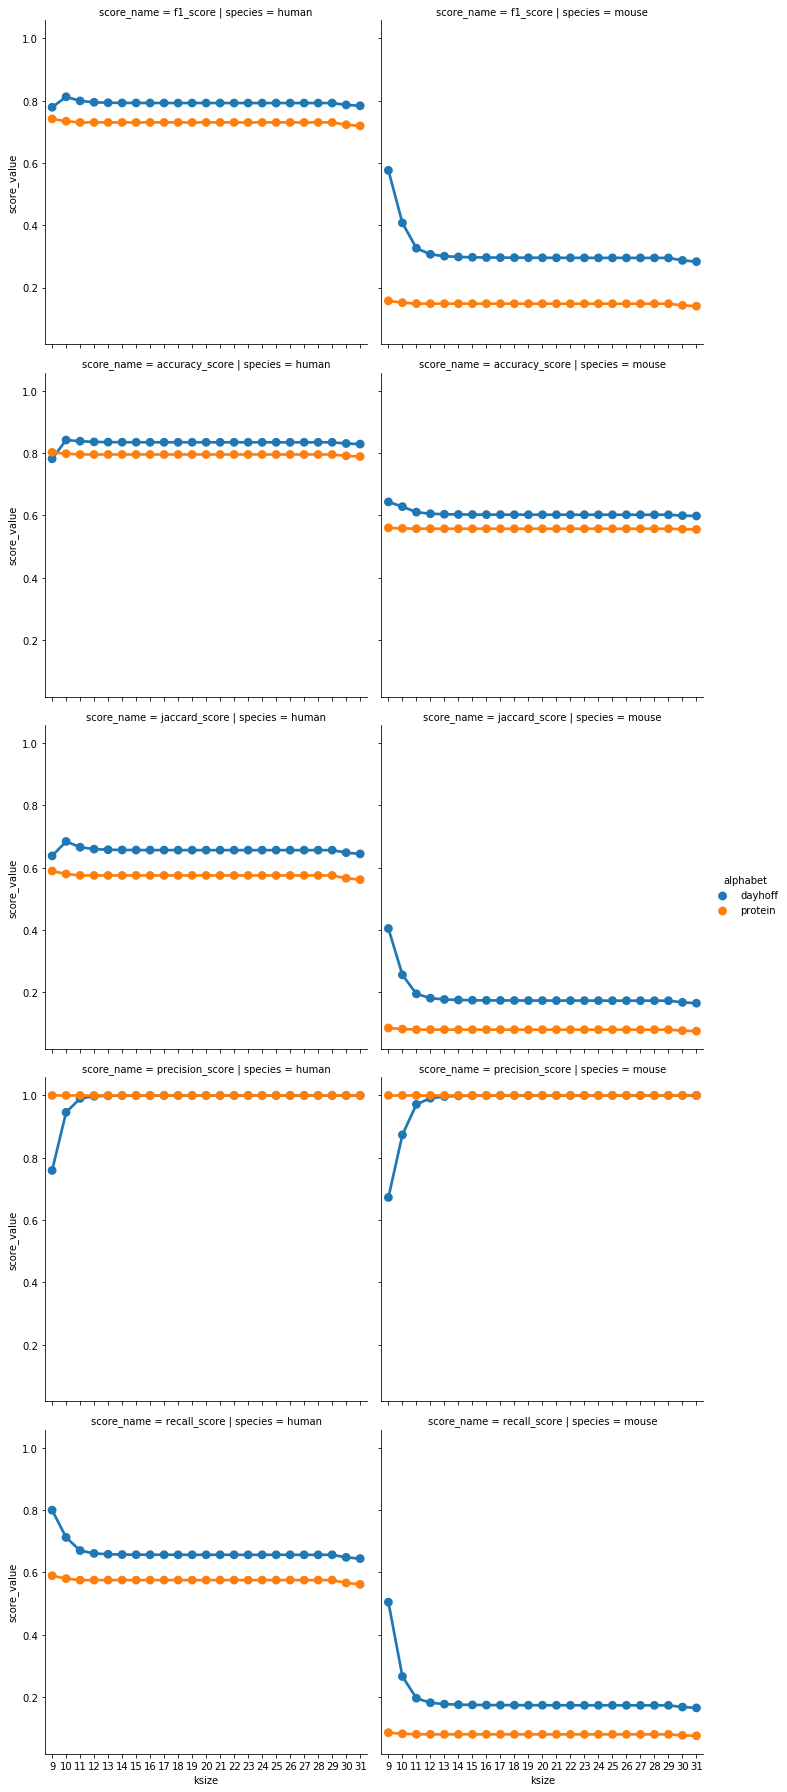

In [70]:
sns.catplot(x='ksize', y='score_value', hue='alphabet', row='score_name', col='species',
            data=combined_metrics, kind='point')

## Compute ROC AUC

### Human

In [88]:
%%time

def compute_roc_auc(coding_results, true_coding_frame=true_coding_frame):
    scores = coding_results.groupby(['species', 'alphabet', 'ksize']).jaccard_in_peptide_db.apply(
        lambda x: sklearn.metrics.roc_auc_score(true_coding_frame[x.index], x))

    scores.name = 'score_value'
    scores_df = scores.reset_index()
    scores_df['score_name'] = 'roc_auc'

    return scores_df

combined_roc_auc_score = compute_roc_auc(combined_scores)
combined_roc_auc_score.head()

CPU times: user 1min 17s, sys: 3.4 s, total: 1min 21s
Wall time: 1min 21s



## Compute ROC Curve

### Human

In [ ]:
%%time

def _get_roc_curve_df(y_true, y_score):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    
    df = pd.DataFrame({'fpr': fpr, 'tpr': tpr, 'thresholds': thresholds})
    df.index.name = 'threshold_i'
    return df



def compute_roc_curve(coding_results, true_coding_frame=true_coding_frame):
    curve_df = coding_results.groupby(['species', 'alphabet', 'ksize']).jaccard_in_peptide_db.apply(
        lambda x: _get_roc_curve_df(true_coding_frame[x.index], x))

    curve_df['score_name'] = 'roc_auc'

    return curve_df

combined_roc_curve = compute_roc_curve(combined_scores)
combined_roc_curve = combined_roc_curve.reset_index()
describe(combined_roc_curve)

In [ ]:
combined_scores

In [116]:
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

In [ ]:
index = true_coding_frame.index.intersection(combined_scores.index)
true_coding_frame_intersect = true_coding_frame.loc[index]
print(true_coding_frame_intersect.shape)
true_coding_frame_intersect.head()

In [ ]:
combined_scores.loc[true_coding_frame_intersect.sample(5, random_state=0).index]

In [99]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_roc_curve.csv'
combined_roc_curve.to_csv(csv, index=False)

# Concatenate ROC AUC with other metrics

## Combine non-curve sscores

In [100]:
concatenated_metrics = pd.concat([combined_roc_auc_score, combined_metrics], ignore_index=True)
describe(concatenated_metrics)

(552, 5)
--- First 5 entries ---


,species,alphabet,ksize,score_value,score_name
0,human,dayhoff,9,0.845092,roc_auc
1,human,dayhoff,10,0.935613,roc_auc
2,human,dayhoff,11,0.976180,roc_auc
3,human,dayhoff,12,0.989243,roc_auc
4,human,dayhoff,13,0.993827,roc_auc


--- Random subset ---


,species,alphabet,ksize,score_value,score_name
117,human,protein,11,0.730359,f1_score
473,human,dayhoff,22,0.656507,recall_score
411,human,protein,29,0.999847,precision_score
63,mouse,dayhoff,26,0.755189,roc_auc
181,mouse,protein,29,0.148611,f1_score


In [101]:
concatenated_metrics.score_name.value_counts()

precision_score    92
f1_score           92
accuracy_score     92
recall_score       92
jaccard_score      92
roc_auc            92
Name: score_name, dtype: int64

### Write combined metrics to csv!!!

In [102]:
csv = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/human_mouse__coding_scores_metrics_concatenated.csv'
concatenated_metrics.to_csv(csv, index=False)

## Which molecule, ksize maximizes each metric?

In [103]:
combined_roc_auc = concatenated_metrics.query('score_name == "roc_auc"')

In [104]:
concatenated_metrics.loc[concatenated_metrics.groupby(['species', 'score_name',]).score_value.idxmax()]

,species,alphabet,ksize,score_value,score_name
185,human,dayhoff,10,0.841815,accuracy_score
93,human,dayhoff,10,0.812582,f1_score
277,human,dayhoff,10,0.684328,jaccard_score
390,human,dayhoff,31,0.999934,precision_score
460,human,dayhoff,9,0.799744,recall_score
24,human,protein,10,0.998755,roc_auc
230,mouse,dayhoff,9,0.643220,accuracy_score
138,mouse,dayhoff,9,0.576503,f1_score
322,mouse,dayhoff,9,0.404990,jaccard_score
436,mouse,dayhoff,31,1.000000,precision_score


In [105]:
combined_roc_auc.loc[combined_roc_auc.groupby(['species', 'score_name',]).score_value.idxmax()]

,species,alphabet,ksize,score_value,score_name
24,human,protein,10,0.998755,roc_auc
69,mouse,protein,9,0.912515,roc_auc


In [106]:
combined_roc_curve.query('(species == "human") & (alphabet == "protein") & (ksize == 11)')

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
5396,human,protein,11,0,0.000000,0.000000,2.000000,roc_auc
5397,human,protein,11,1,0.000037,0.561638,1.000000,roc_auc
5398,human,protein,11,2,0.000054,0.566188,0.975000,roc_auc
5399,human,protein,11,3,0.000082,0.575268,0.974359,roc_auc
5400,human,protein,11,4,0.000082,0.575280,0.973684,roc_auc
5401,human,protein,11,5,0.000085,0.575289,0.972973,roc_auc
5402,human,protein,11,6,0.000085,0.575301,0.954545,roc_auc
5403,human,protein,11,7,0.000090,0.580006,0.950000,roc_auc
5404,human,protein,11,8,0.000090,0.589438,0.948718,roc_auc
5405,human,protein,11,9,0.000090,0.589447,0.947368,roc_auc


In [ ]:
combined_roc_curve.

In [107]:
combined_roc_curve.query('(species == "mouse") & (alphabet == "protein") & (ksize == 9)')

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
12516,mouse,protein,9,0,0.000000,0.000000,2.000000,roc_auc
12517,mouse,protein,9,1,0.000000,0.075918,1.000000,roc_auc
12518,mouse,protein,9,2,0.000000,0.077414,0.976190,roc_auc
12519,mouse,protein,9,3,0.000000,0.080569,0.975610,roc_auc
12520,mouse,protein,9,4,0.000000,0.080587,0.972973,roc_auc
12521,mouse,protein,9,5,0.000000,0.080590,0.971429,roc_auc
12522,mouse,protein,9,6,0.000000,0.082247,0.952381,roc_auc
12523,mouse,protein,9,7,0.000000,0.085702,0.951220,roc_auc
12524,mouse,protein,9,8,0.000000,0.085711,0.950000,roc_auc
12525,mouse,protein,9,9,0.000000,0.085717,0.947368,roc_auc


In [108]:
combined_roc_curve.query('(species == "mouse") & (alphabet == "dayhoff") & (ksize == 16)')

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name
10121,mouse,dayhoff,16,0,0.000000,0.000000,2.000000,roc_auc
10122,mouse,dayhoff,16,1,0.000045,0.166045,1.000000,roc_auc
10123,mouse,dayhoff,16,2,0.000048,0.168714,0.971429,roc_auc
10124,mouse,dayhoff,16,3,0.000048,0.174257,0.970588,roc_auc
10125,mouse,dayhoff,16,4,0.000048,0.174260,0.969697,roc_auc
10126,mouse,dayhoff,16,5,0.000048,0.174267,0.968750,roc_auc
10127,mouse,dayhoff,16,6,0.000048,0.174270,0.967742,roc_auc
10128,mouse,dayhoff,16,7,0.000051,0.174273,0.966667,roc_auc
10129,mouse,dayhoff,16,8,0.000054,0.174279,0.965517,roc_auc
10130,mouse,dayhoff,16,9,0.000054,0.174288,0.964286,roc_auc


In [109]:
# combined_roc_curve.loc[[('human', 'protein', 11), ('mouse', 'protein', 9), ('mouse', 'dayhoff', 11)], :]

## Plot combined metrics

### Groupby score name, one by one

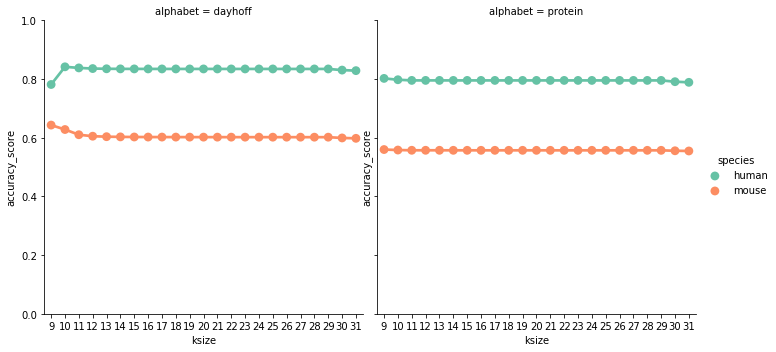

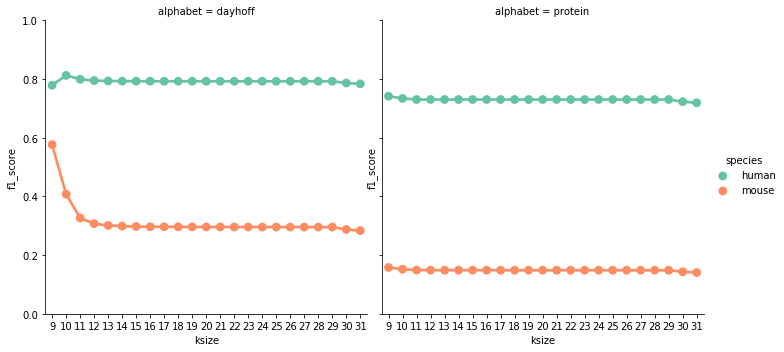

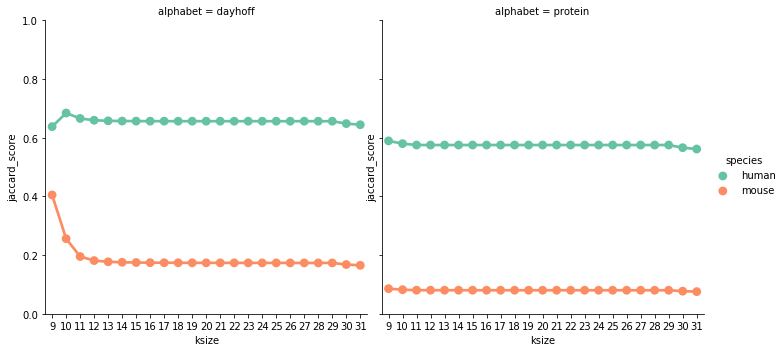

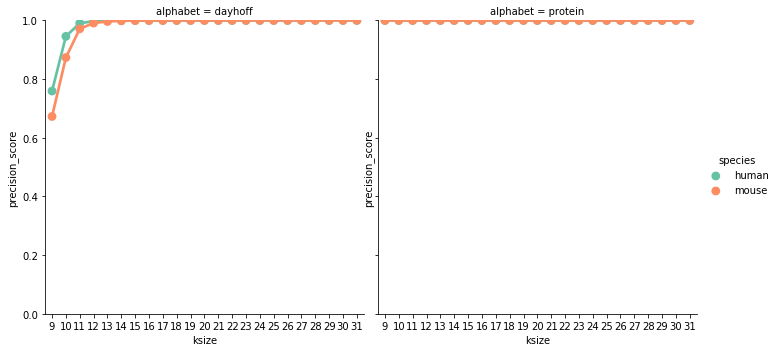

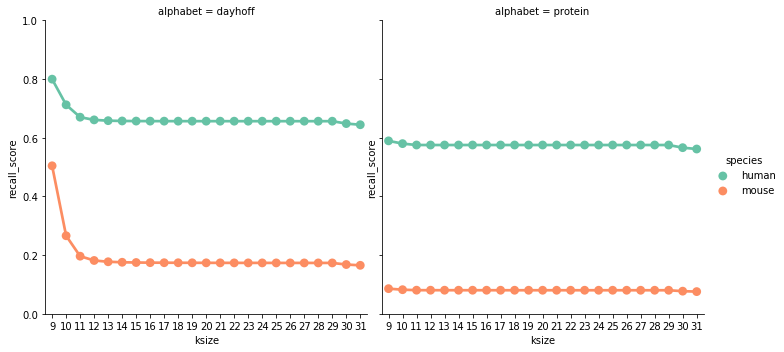

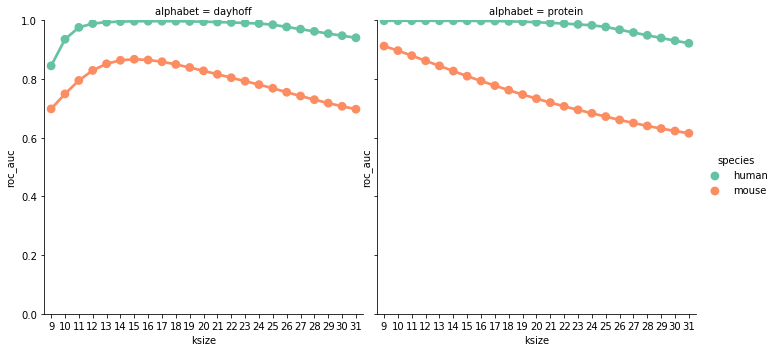

In [110]:
for score_name, df in concatenated_metrics.groupby('score_name'):
    g = sns.catplot(x='ksize', y='score_value', hue='species', col='alphabet', 
            data=df, kind='point', palette="Set2")
    g.set(ylabel=score_name, ylim=(0, 1))

## Just plot ROC AUC

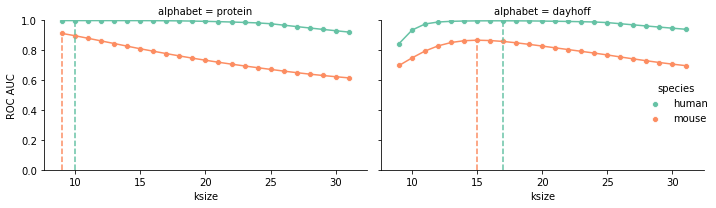

In [111]:
def plot_argmax(x, y, *args, **kwargs):
    idxmax = y.idxmax()
    plt.vlines(x[idxmax], 0, y.max(), linestyle='--', *args, **kwargs)
#     print('x:', x)
#     print('y:', y)
#     print('args:', args)
#     print('kwargs:', kwargs)
    pass

alphabet_order = ['protein', 'dayhoff']
g = sns.FacetGrid( hue='species', col='alphabet', col_order=alphabet_order,
        data=combined_roc_auc, palette="Set2", height=3, aspect=1.5)
g.map(sns.scatterplot, 'ksize', 'score_value')
g.add_legend()
g.map(plt.plot, 'ksize', 'score_value')
g.map(plot_argmax, 'ksize', 'score_value')
g.set(ylabel='ROC AUC', ylim=(0, 1))


### All in one grid

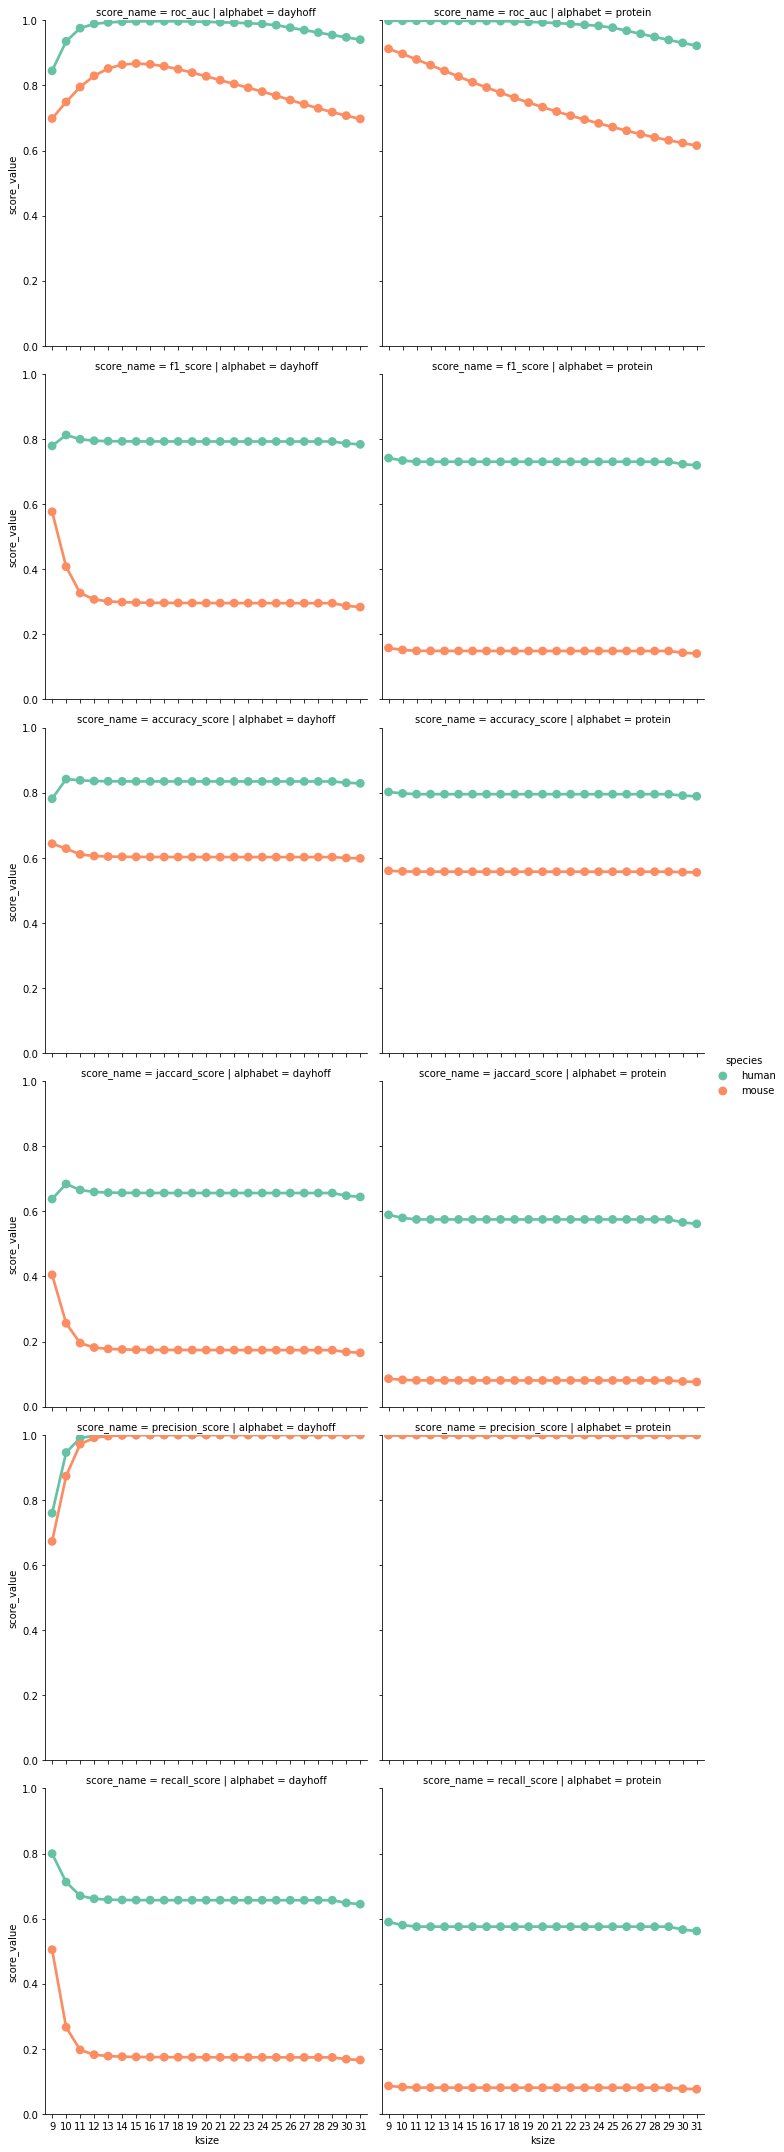

In [112]:
g = sns.catplot(x='ksize', y='score_value', hue='species', col='alphabet', 
        data=concatenated_metrics, kind='point', palette='Set2', row='score_name')
g.set(ylim=(0, 1 ))

## Plot ROC curves

### Plot combined roc curves

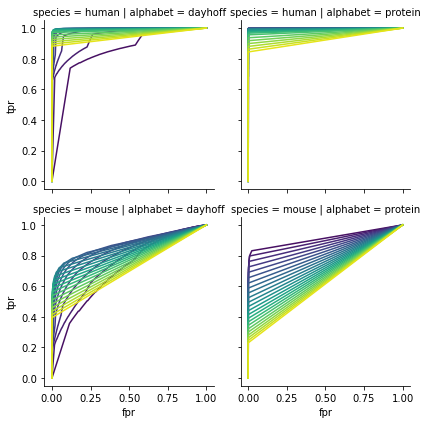

In [113]:

g = sns.FacetGrid(data=combined_roc_curve, col='alphabet', hue='ksize', palette='viridis', row='species')
g.map(plt.plot, 'fpr', 'tpr')

## Get derivative/difference of 

In [133]:
roc_derivatives = combined_roc_curve.groupby(['species', 'alphabet', 'ksize']).apply(lambda x: x.tpr.diff()/x.fpr.diff())
print(roc_derivatives.shape)
roc_derivatives.head()

(15196,)


species  alphabet  ksize   
human    dayhoff   9      0         NaN
                          1    6.244312
                          2    0.633392
                          3    0.560947
                          4    0.071403
dtype: float64

In [134]:
combined_roc_curve.shape

(15196, 8)

## What species, alphabet, ksize maximizes the derivative

In [135]:
combined_roc_curve['roc_derivative'] = roc_derivatives.values
print(combined_roc_curve.shape)
combined_roc_curve.head()

(15196, 9)


,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,roc_derivative
0,human,dayhoff,9,0,0.000000,0.000000,2.00000,roc_auc,NaN
1,human,dayhoff,9,1,0.118264,0.738477,1.00000,roc_auc,6.244312
2,human,dayhoff,9,2,0.137104,0.750411,0.97619,roc_auc,0.633392
3,human,dayhoff,9,3,0.177572,0.773111,0.97561,roc_auc,0.560947
4,human,dayhoff,9,4,0.179528,0.773251,0.97500,roc_auc,0.071403


In [ ]:
combined_roc_auc.loc[combined_roc_auc.groupby(['species', 'score_name',]).score_value.idxmax()]

In [ ]:
combined_roc_curve.loc[combined_roc_curve.query('tpr >= 0.9').groupby(['species', 'alphabet']).roc_derivative.idxmax()]

In [137]:
combined_roc_curve.loc[combined_roc_curve.groupby(['species', 'alphabet']).roc_derivative.idxmax()]

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,roc_derivative
153,human,dayhoff,9,153,0.703789,0.984763,0.708333,roc_auc,inf
4899,human,protein,9,4,0.000082,0.575300,0.975000,roc_auc,inf
7351,mouse,dayhoff,9,22,0.176890,0.438842,0.954545,roc_auc,inf
12517,mouse,protein,9,1,0.000000,0.075918,1.000000,roc_auc,inf


### What about with a true positive rate > some value?

In [154]:
combined_roc_curve.loc[combined_roc_curve.query('(tpr >= 0.75) & (fpr < 0.1)').groupby(['species', 'alphabet']).roc_derivative.idxmax()]

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,roc_derivative
1428,human,dayhoff,12,216,0.071409,0.973155,0.520000,roc_auc,inf
4957,human,protein,9,62,0.000242,0.893376,0.777778,roc_auc,inf
10432,mouse,dayhoff,16,311,0.088936,0.754570,0.038462,roc_auc,inf
12832,mouse,protein,9,316,0.009970,0.801748,0.034483,roc_auc,inf


In [143]:
combined_roc_curve.loc[combined_roc_curve.query('(tpr >= 0.9) & (fpr < 0.1)').groupby(['species', 'alphabet']).roc_derivative.idxmax()]

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,roc_derivative
1428,human,dayhoff,12,216,0.071409,0.973155,0.52,roc_auc,inf
4967,human,protein,9,72,0.000254,0.903163,0.75,roc_auc,inf


In [144]:
combined_roc_curve.loc[combined_roc_curve.query('(tpr >= 0.95) & (fpr < 0.1)').groupby(['species', 'alphabet']).roc_derivative.idxmax()]

,species,alphabet,ksize,threshold_i,fpr,tpr,thresholds,score_name,roc_derivative
1428,human,dayhoff,12,216,0.071409,0.973155,0.52,roc_auc,inf
5003,human,protein,9,108,0.000347,0.953189,0.60,roc_auc,inf


In [160]:

combined_roc_curve.query('(tpr >= 0.8) & (fpr < 0.1)').groupby(['species', 'alphabet', 'ksize']).roc_derivative.apply(lambda x: x.nlargest(3))


species  alphabet  ksize       
human    dayhoff   11     915        9.429728
                          919        7.932131
                          891        3.218856
                   12     1428            inf
                          1351      33.741329
                          1355      26.833234
                   13     1814            inf
                          1770      75.008314
                          1776      64.874279
                   14     2164     170.471299
                          2169     117.946585
                          2153      27.203826
                   15     2524            inf
                          2553            inf
                          2531     232.490519
                   16     2819            inf
                          2829            inf
                          2848            inf
                   17     3120            inf
                          3128            inf
                          3124     257.301357
  